<a href="https://colab.research.google.com/github/limedosa/Bat-Population-Decline/blob/main/Bat%20Population%20Decline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade scikit-learn
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import sklearn
print(sklearn.__version__)

1.3.2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import transformers

import keras
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
### NOTE: Make sure to add this to shortcut in your google drive
df = pd.read_csv('/content/Modeling(1).csv')
#df = pd.read_csv('/content/drive/MyDrive/Merged.csv')
#df = pd.read_csv('/content/drive/MyDrive/Biointerphase (BOS) - AI Guided Prediction of Bat Populations from White-Nose Syndrome (Team A)/CURRENTLY WORKING ON Colab and Data /Modeling(1).csv')

df.head()

,Unnamed: 0,Sample Collection Date,Host Group,Sample Location - County,Sample Location - State,CFU,Fungus Classification - Phylum,Fungus Classification - Class,Fungus Classification - Order,Fungus Classification - Family,Fungus Classification - Genus,Fungus Classification - Species,pd_present_in_pop
0,0,2014-02-11,Resistant,Pendleton,West Virginia,6,Ascomycota,Eurotiomycetes,Onygenales,Gymnoascaceae,NaN,NaN,1
1,1,2014-02-11,Resistant,Pendleton,West Virginia,1,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Debaryomyces,hansenii,1
2,2,2014-02-11,Resistant,Pendleton,West Virginia,6,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Debaryomyces,hansenii,1
3,3,2014-02-11,Resistant,Pendleton,West Virginia,1,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Debaryomyces,NaN,1
4,4,2014-02-11,Resistant,Pendleton,West Virginia,3,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Debaryomyces,NaN,1


In [ ]:
#does not work
# combined_string = ""

# for i in df['Sample Location - State']:
#   combined_string ", ".join(elements)

Model building stuff:
Goal: Calculate the liklihood that at a given time a bat population will develop WNS.

We cannot output the liklihood. We can have the model output it's certanty of a given guess, I think.

I think we're going to have to use NLP techniques to achieve the goal. The issue is that we can't one-hot-encode all the locations (yes we can for the sake of the argument), and we definetly can't encode all of the fungi types(I'M GONNA TRY). What I think we can do however is combine the locations into one big text string, tokenize the text string (doesn't need to be advanced, we just need to make the words into numbers) and then use if WNS is present in the population or not as a binary classification task. Output a confusion matrix and some examples of heavily-weighted and less-weighted things, and there we are, we're good to go.
Constructed string will be in the following format:

[Site, state, date, (classification of the fungi)]

It'll be weird, but so long as it's in the proper format I think we're good to go. From there we can test out different NLP techniques and figure out what works best. This is still a LOT of work though. It'll be fine, I'll just get as much as I can done tonight.

One-hot encoding everything

In [ ]:
# dummy_county = pd.get_dummies(df["Sample Location - County"]) # 22 columns
# dummy_state = pd.get_dummies(df["Sample Location - State"]) #15 columns
dummy_host = pd.get_dummies(df["Host Group"]) # 4 columns
dummy_phylum = pd.get_dummies(df["Fungus Classification - Phylum"]) #4 columns
dummy_class = pd.get_dummies(df["Fungus Classification - Class"]) # 15 columns
dummy_order = pd.get_dummies(df["Fungus Classification - Order"]) # 33 columns
dummy_family = pd.get_dummies(df["Fungus Classification - Family"]) # 57 columns
dummy_genus = pd.get_dummies(df["Fungus Classification - Genus"]) # 70 columns
dummy_species = pd.get_dummies(df["Fungus Classification - Species"]) #73 columns
#total of 293 columns

In [ ]:
#concatenate all things into a giant dataframe
one_hot_df = pd.concat([df["Sample Collection Date"], dummy_host, df["CFU"], dummy_phylum, dummy_class, dummy_order, dummy_family, dummy_species,dummy_genus, df["pd_present_in_pop"]], axis = 1)
one_hot_df

,Sample Collection Date,Resistant,Susceptible,Tolerant,unassigned,CFU,Ascomycota,Basidiomycota,Mortierellomycota,Mucoromycota,...,Torulaspora,Tremella,Trichoderma,Trichomonascus,Trichosporon,Verticillium,Vishniacozyma,Wardomyces,Yamadazyma,pd_present_in_pop
0,2014-02-11,1,0,0,0,6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2014-02-11,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2014-02-11,1,0,0,0,6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2014-02-11,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2014-02-11,1,0,0,0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,2016-01-05,0,0,0,0,no fungi isolated,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
858,2016-01-05,0,0,0,0,no fungi isolated,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
859,2015-12-21,0,0,0,0,18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,2015-12-21,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
one_hot_df.to_csv('/content/one_hot_model_data_without_county_and_state.csv')

Making Everything into words

In [ ]:
df.head()

,Unnamed: 0,Sample Collection Date,Host Group,Sample Location - County,Sample Location - State,CFU,Fungus Classification - Phylum,Fungus Classification - Class,Fungus Classification - Order,Fungus Classification - Family,Fungus Classification - Genus,Fungus Classification - Species,pd_present_in_pop
0,0,2014-02-11,Resistant,Pendleton,West Virginia,6,Ascomycota,Eurotiomycetes,Onygenales,Gymnoascaceae,NaN,NaN,1
1,1,2014-02-11,Resistant,Pendleton,West Virginia,1,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Debaryomyces,hansenii,1
2,2,2014-02-11,Resistant,Pendleton,West Virginia,6,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Debaryomyces,hansenii,1
3,3,2014-02-11,Resistant,Pendleton,West Virginia,1,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Debaryomyces,NaN,1
4,4,2014-02-11,Resistant,Pendleton,West Virginia,3,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Debaryomyces,NaN,1


In [ ]:
#df['combined'] = df[["Sample Collection Date", "Host Group", "Sample Location - County", "Sample Location - State", "CFU", 'Fungus Classification - Phylum', "Fungus Classification - Class","Fungus Classification - Order", "Fungus Classification - Family", "Fungus Classification - Genus", "Fungus Classification - Species" ]].astype(str).agg(' '.join, axis=1)
#df['combined'] = df[["Host Group", "Sample Location - County", "Sample Location - State", "CFU", 'Fungus Classification - Phylum', "Fungus Classification - Class","Fungus Classification - Order", "Fungus Classification - Family", "Fungus Classification - Genus", "Fungus Classification - Species" ]].astype(str).agg(' '.join, axis=1)
#df['combined'] = df[["CFU", 'Fungus Classification - Phylum', "Fungus Classification - Class","Fungus Classification - Order", "Fungus Classification - Family", "Fungus Classification - Genus", "Fungus Classification - Species" ]].astype(str).agg(' '.join, axis=1)
#df['combined'] = df[[ "Sample Location - County", "Sample Location - State", "Fungus Classification - Genus", "Fungus Classification - Species" ]].astype(str).agg(' '.join, axis=1)
#df['combined'] = df[["Sample Collection Date", "Sample Location - County", "Sample Location - State", "CFU"]].astype(str).agg(' '.join, axis=1)
#df['combined'] = df[["Sample Collection Date", "Host Group", "Sample Location - County", "Sample Location - State", "CFU"]].astype(str).agg(' '.join, axis=1)
#df['combined'] = df[["Sample Location - County", "Sample Location - State"]].astype(str).agg(' '.join, axis=1)
# df['combined'] = df[["Sample Location - State"]].astype(str).agg(' '.join, axis=1)
# df['combined'] = df[["Sample Collection Date",	"Host Group","CFU",	"Fungus Classification - Phylum",	"Fungus Classification - Class",	"Fungus Classification - Order",	"Fungus Classification - Family",	"Fungus Classification - Genus",	"Fungus Classification - Species"]].astype(str).agg(' '.join, axis=1)
# df['combined'] = df[["Fungus Classification - Phylum",	"Fungus Classification - Class",	"Fungus Classification - Order",	"Fungus Classification - Family",	"Fungus Classification - Genus",	"Fungus Classification - Species"]].astype(str).agg(' '.join, axis=1)
# df['combined'] = df[["Sample Collection Date",	"Fungus Classification - Phylum",	"Fungus Classification - Class",	"Fungus Classification - Order",	"Fungus Classification - Family",	"Fungus Classification - Genus",	"Fungus Classification - Species"]].astype(str).agg(' '.join, axis=1)
# df['combined'] = df[["Sample Collection Date"]].astype(str).agg(' '.join, axis=1)
df['combined'] = df[["Host Group", "CFU",	"Fungus Classification - Phylum",	"Fungus Classification - Class",	"Fungus Classification - Order",	"Fungus Classification - Family",	"Fungus Classification - Genus",	"Fungus Classification - Species"]].astype(str).agg(' '.join, axis=1)
# df['combined'] = df[["Host Group"]].astype(str).agg(' '.join, axis=1)
#df['combined'] = df[["Host Group", "CFU", 'Fungus Classification - Phylum', "Fungus Classification - Class","Fungus Classification - Order", "Fungus Classification - Family", "Fungus Classification - Genus", "Fungus Classification - Species" ]].astype(str).agg(' '.join, axis=1)

df.head()

,Unnamed: 0,Sample Collection Date,Host Group,Sample Location - County,Sample Location - State,CFU,Fungus Classification - Phylum,Fungus Classification - Class,Fungus Classification - Order,Fungus Classification - Family,Fungus Classification - Genus,Fungus Classification - Species,pd_present_in_pop,combined
0,0,2014-02-11,Resistant,Pendleton,West Virginia,6,Ascomycota,Eurotiomycetes,Onygenales,Gymnoascaceae,NaN,NaN,1,Resistant 6 Ascomycota Eurotiomycetes Onygenal...
1,1,2014-02-11,Resistant,Pendleton,West Virginia,1,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Debaryomyces,hansenii,1,Resistant 1 Ascomycota Saccharomycetes Sacchar...
2,2,2014-02-11,Resistant,Pendleton,West Virginia,6,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Debaryomyces,hansenii,1,Resistant 6 Ascomycota Saccharomycetes Sacchar...
3,3,2014-02-11,Resistant,Pendleton,West Virginia,1,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Debaryomyces,NaN,1,Resistant 1 Ascomycota Saccharomycetes Sacchar...
4,4,2014-02-11,Resistant,Pendleton,West Virginia,3,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Debaryomyces,NaN,1,Resistant 3 Ascomycota Saccharomycetes Sacchar...


In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased')
# Convert the pandas Series to a list of strings
text_list = df['combined'].tolist()

# Encode the combined string using BERT
X_encoded = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')["input_ids"]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(len(X_encoded))
print(len(df["pd_present_in_pop"]))

862
862


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['combined'], df['pd_present_in_pop'], test_size=0.2, random_state=42)

In [ ]:
# 1. Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer()

# 2. Fit the vectorizer to X_train
tfidf_vectorizer.fit(X_train)

# 3. Using the fitted vectorizer, transform the training data
X_train_tfidf = tfidf_vectorizer.transform(X_train)


# 4. Using the fitted vectorizer, transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)



In [ ]:
vocabulary_size = len(tfidf_vectorizer.vocabulary_)

print(vocabulary_size)

281


In [ ]:
# 1. Create model object
nn_model = keras.Sequential()

# 2. Create the input layer and add it to the model object:
# Create input layer:
input_layer = keras.layers.InputLayer(input_shape=(vocabulary_size,))
# Add input_layer to the model object:
nn_model.add(input_layer)



# 3. Create the first hidden layer and add it to the model object:

# Create input layer:
hidden_layer_1 = keras.layers.Dense(units = 64, activation = 'relu')

# Add hidden_layer_1 to the model object:
nn_model.add(hidden_layer_1)
nn_model.add(keras.layers.Dropout(.25))



# 4. Create the second layer and add it to the model object:

# Create input layer:
hidden_layer_2 = keras.layers.Dense(units = 32, activation = 'relu')

# Add hidden_layer_2 to the model object:
nn_model.add(hidden_layer_2)
nn_model.add(keras.layers.Dropout(.25))


# 5. Create the third layer and add it to the model object:

# Create input layer:
hidden_layer_3 = keras.layers.Dense(units = 16, activation = 'relu')

# Add hidden_layer_3 to the model object:
nn_model.add(hidden_layer_3)
nn_model.add(keras.layers.Dropout(.25))
# 6. Create the output layer and add it to the model object:

# Create input layer:
output_layer = keras.layers.Dense(units = 1, activation = 'sigmoid')

# Add output_layer to the model object:
nn_model.add(output_layer)


# Print summary of neural network model structure
nn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                18048     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
sgd_optimizer= keras.optimizers.SGD(learning_rate=0.1)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
nn_model.compile(optimizer = sgd_optimizer, loss = loss_fn, metrics=['accuracy'])

In [ ]:
class ProgBarLoggerNEpochs(keras.callbacks.Callback):

    def __init__(self, num_epochs: int, every_n: int = 50):
        self.num_epochs = num_epochs
        self.every_n = every_n

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n == 0:
            s = 'Epoch [{}/ {}]'.format(epoch + 1, self.num_epochs)
            logs_s = ['{}: {:.4f}'.format(k.capitalize(), v)
                      for k, v in logs.items()]
            s_list = [s] + logs_s
            print(', '.join(s_list))

In [ ]:
t0 = time.time() # start time

num_epochs = 25 #epochs

history = nn_model.fit(X_train_tfidf.toarray(), y_train, epochs=num_epochs, verbose=1,callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=50)], validation_split=0.2)



t1 = time.time() # stop time

print('Elapsed time: %.2fs' % (t1-t0))



Epoch 1/25
18/18 [==============================] - 1s 12ms/step - loss: 0.6926 - accuracy: 0.5172 - val_loss: 0.6915 - val_accuracy: 0.4928
Epoch 2/25
18/18 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5390 - val_loss: 0.6919 - val_accuracy: 0.4928
Epoch 3/25
18/18 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.5426 - val_loss: 0.6848 - val_accuracy: 0.4928
Epoch 4/25
18/18 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5898 - val_loss: 0.6796 - val_accuracy: 0.5797
Epoch 5/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6737 - accuracy: 0.6062 - val_loss: 0.6755 - val_accuracy: 0.6014
Epoch 6/25
18/18 [==============================] - 0s 9ms/step - loss: 0.6613 - accuracy: 0.6134 - val_loss: 0.6644 - val_accuracy: 0.5942
Epoch 7/25
18/18 [==============================] - 0s 6ms/step - loss: 0.6576 - accuracy: 0.6334 - val_loss: 0.6640 - val_accuracy: 0.6087
Epoch 8/25
18/18 [=

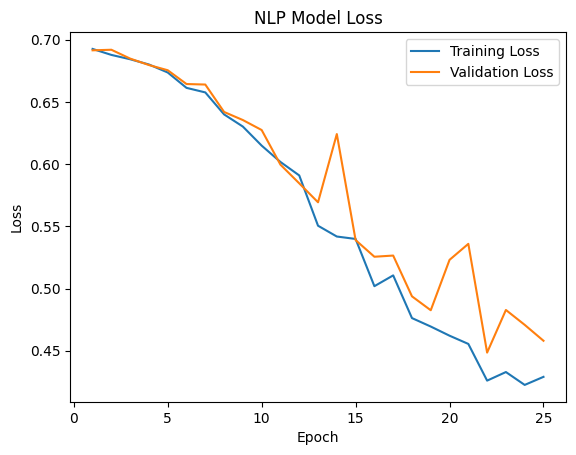

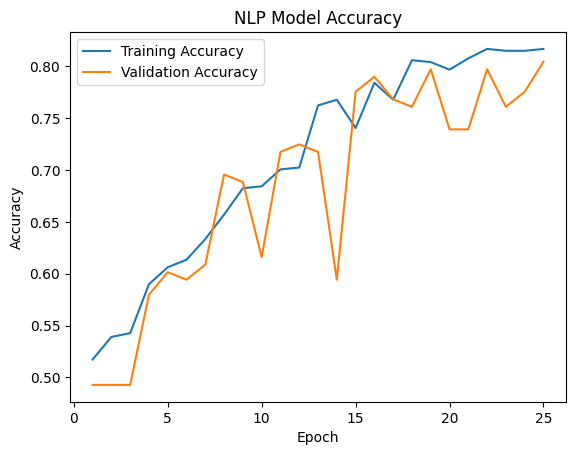

In [ ]:
# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('NLP Model Loss')
plt.show()


# Plot training and validation accuracy
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('NLP Model Accuracy')
plt.show()


In [ ]:
loss, accuracy = nn_model.evaluate(X_test_tfidf.toarray(), y_test)


print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

6/6 [==============================] - 0s 3ms/step - loss: 0.4030 - accuracy: 0.8208
Loss:  0.4030328094959259 Accuracy:  0.8208092451095581


In [ ]:

probability_predictions = nn_model.predict(X_test_tfidf.toarray())
y_test_list = []
for y in y_test:
  y_test_list.append(y)

x_test_list = []
for x in X_test:
  x_test_list.append(x)

print("Predictions for the random 10 examples:")
print("Probability\t\t\tPredicted\t\t\tActual")
index = np.random.choice(len(y_test_list),10)

for i in index:
    if probability_predictions[i] >= .5:
        class_pred = "1" #class 1 (present)
    else:
        class_pred = "0" #class 0 (absent)
    print(str(probability_predictions[i]) + "\t\t\t" + str(class_pred)+ "\t\t\t"+ str(y_test_list[i]) + "\t\t\t"+str(x_test_list[i]))

6/6 [==============================] - 0s 2ms/step
Predictions for the random 10 examples:
Probability			Predicted			Actual
[0.8975329]			1			1			Resistant 2 Basidiomycota Cystobasidiomycetes Cystobasidiales Cystobasidiaceae Cystobasidium pinicola
[0.18648271]			0			0			nan 4 Ascomycota Leotiomycetes Helotiales Helotiaceae Collophora nan
[0.1425254]			0			1			Susceptible 100 Basidiomycota Microbotryomycetes Leucosporidiales Leucosporidiaceae Leucosporidium nan
[0.83437896]			1			1			unassigned 18 Basidiomycota Tremellomycetes Holtermanniales incertae sedis Holtermanniella takashimae
[0.9770648]			1			1			unassigned 24 Ascomycota Leotiomycetes Thelebolales Pseudeurotiaceae Pseudogymnoascus destructans
[0.98460156]			1			1			unassigned 13 Ascomycota Leotiomycetes Thelebolales Pseudeurotiaceae Pseudogymnoascus destructans
[0.9114031]			1			1			Susceptible 100 Ascomycota Leotiomycetes Thelebolales Pseudeurotiaceae Pseudogymnoascus destructans
[0.9819535]			1			1			unassigned 12 Ascomycota 

Next step: start removing features and see how accuracy declines:


All Features: 0.9826589822769165

remove "Sample Collection Date" :1.0000

Just Classification and CFU: 0.6878612637519836

Just Class, Genus, state, County: 1.0

Just State, County, Date, CFU: 0.9942196607589722

State, County, Date, CFU, Host group: 0.9942196607589722

State, County: 1.0000

State: 0.9421965479850769

remove State, County: 0.9248554706573486

only classifications: 0.7109826803207397

Time, classification: 0.9421965479850769

only Time: 0.9595375657081604

Host Group, CFU, Fungus Classification (remove State, County, Time): 0.8612716794013977

only CFU: 0.8323699235916138


Make a confusion Matrix

** Insights: **

1. classification doesn't look like it helps the model, so location and date are more essential.

2. State and County are basically directly correlated with the output. They should not be added to the model.

3. Sample Collection Date (Time) only '2014-03-04' repeated in both label. Time maybe should not be added to the model as well.

4. Host Group: Resistent --> Yes WNS


*Fungus Classification inspect:*

Missing WNS present with non-WNS fungus present

Text(0.5, 1.0, 'Confusion Matrix of NLP Model Prediction')

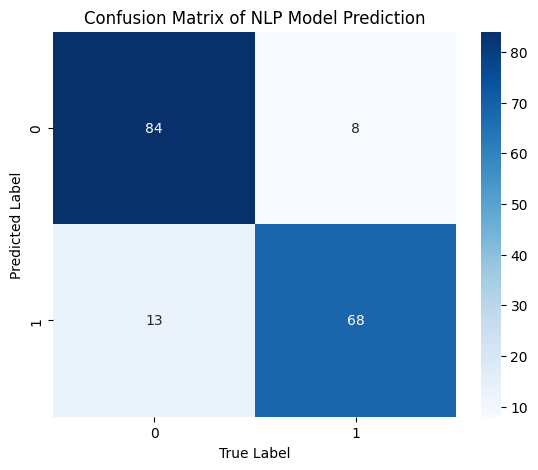

In [ ]:
y_predict_list = ["WNS Present" if i>.5 else "WNS Not Present" for i in probability_predictions]
y_true_list = ["WNS Present" if j==1 else "WNS Not Present" for j in y_test_list]
confusion_mtx = confusion_matrix(y_true_list, y_predict_list)

fig, ax = plt.subplots(figsize=(6.5,5))
ax = sns.heatmap(confusion_mtx, annot =True, fmt='d', ax=ax, cmap = 'Blues')
ax.set_ylabel('Predicted Label')
ax.set_xlabel('True Label')
ax.set_title('Confusion Matrix of NLP Model Prediction')

In [ ]:
df_no_wns = df[df["pd_present_in_pop"] == 0]
# df_no_wns["Sample Location - County"].unique()
# print(df_no_wns['Sample Collection Date'].unique())
# print(df_no_wns['Host Group'].unique())
print(df_no_wns['CFU'].unique())

['1' '2' '6' '4' '15' '5' '3' '50' '7' '8' '200' '71' '100' '32' '500'
 '45' '9' '12' '46' '33' '17' '29' '20' '88' '13' '39' '18' '30' '26' '22'
 '31' '106' '10' '62' '53' '38' '103' '28' '27' '48' '55' '11' '24' '35'
 'no fungi isolated' '19' '41' '14' '300']


In [ ]:
df_wns = df[df["pd_present_in_pop"] == 1]
# df_wns["Sample Location - County"].unique()
# print(df_wns['Sample Collection Date'].unique())
# print(df_wns['Host Group'].unique())
print(df_wns['CFU'].unique())

['6' '1' '3' '7' '24' '5' '8' '49' '4' '2' '16' '52' '100' '10' '25' '12'
 '50' '42' '41' '28' '33' '73' '15' '400' '30' '36' '200' '11' '300' '20'
 '9' '37' '53' '56' '13' '46' '70' '63' '75' '101' '59' '17' '51' '18'
 '35' '62' '67' '60' '23' '34' 'no fungi isolated']


There is no overlap between the counties with WNS and the counties without WNS. This means that the features column with the county name is a direct 1-1 predictor of the test column.

We should not use the county name column.

Two states are repeated.

In [ ]:
probability_predictions = nn_model.predict(X_test_tfidf.toarray())
y_test_list = []
for y in y_test:
  y_test_list.append(y)

x_test_list = []
for x in X_test:
  x_test_list.append(x)




6/6 [==============================] - 0s 5ms/step


In [ ]:
true_pos = ""
true_neg = ""
false_pos = ""
false_neg = ""
for i in range(len(y_test)):
  if (probability_predictions[i]> .5) & (y_test_list[i] == 1):
    true_pos+=" "+ x_test_list[i]
  if (probability_predictions[i]> .5) & (y_test_list[i] == 0):
    false_pos+= " " + x_test_list[i]
  if (probability_predictions[i]< .5) & (y_test_list[i] == 0):
    true_neg+=" " + x_test_list[i]
  if (probability_predictions[i]< .5) & (y_test_list[i] == 1):
    false_neg += " " + x_test_list[i]

In [ ]:
#visualization: List correct and incorrect by false positive and false negative?
#Make a word cloud by the kinds of words correctly and incorrectly put into each category.
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
from PIL import Image

In [ ]:
print(true_pos)

 Susceptible 100 Ascomycota Leotiomycetes Thelebolales Pseudeurotiaceae Pseudogymnoascus destructans Tolerant 50 Ascomycota Leotiomycetes Thelebolales Pseudeurotiaceae Pseudogymnoascus destructans Susceptible 1 Basidiomycota Malasseziomycetes Malasseziales Malasseziaceae Malassezia nan unassigned 13 Ascomycota Leotiomycetes Thelebolales Pseudeurotiaceae Pseudogymnoascus destructans Resistant 1 Ascomycota Sordariomycetes Glomerellales Plectosphaerellaceae Verticillium leptobactrum Tolerant 300 Ascomycota Saccharomycetes Saccharomycetales Debaryomycetaceae Debaryomyces hansenii Susceptible 8 Ascomycota Leotiomycetes Thelebolales Pseudeurotiaceae Pseudeurotium nan unassigned 2 Ascomycota Leotiomycetes Thelebolales Pseudeurotiaceae Pseudogymnoascus destructans unassigned 67 Ascomycota Leotiomycetes Thelebolales Pseudeurotiaceae Pseudogymnoascus destructans Resistant 1 Basidiomycota Tremellomycetes Tremellales Tremellaceae Cryptococcus nan Tolerant 1 Ascomycota Leotiomycetes Thelebolales Ps

In [ ]:
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",width=800, height=400, random_state = 2).generate(true_pos)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('content\true_pos.eps', format='eps')

NameError: ignored

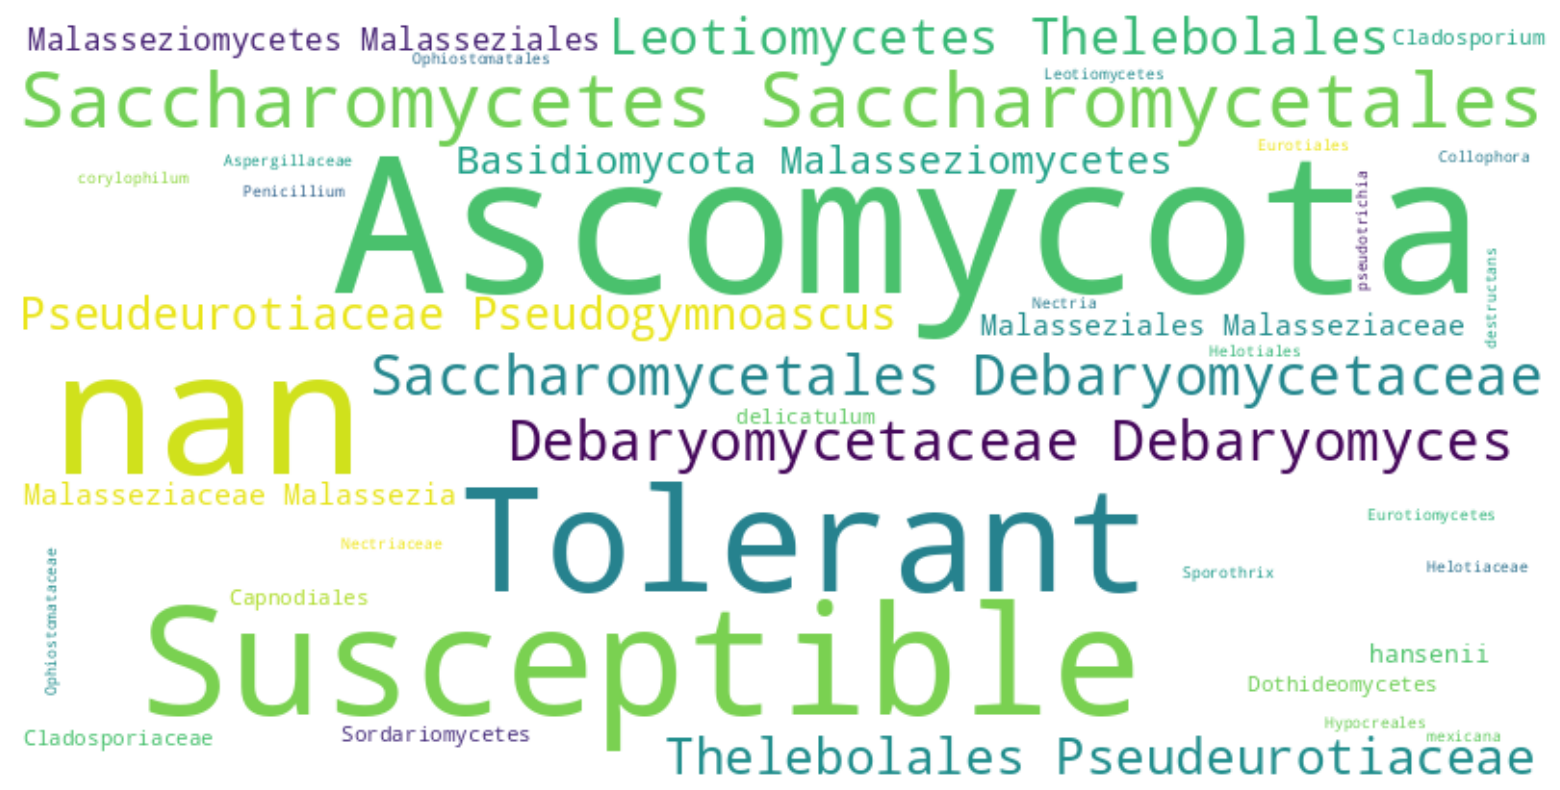

<Figure size 640x480 with 0 Axes>

In [ ]:
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",width=800, height=400).generate(false_pos)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('content\false_pos.eps', format='eps')

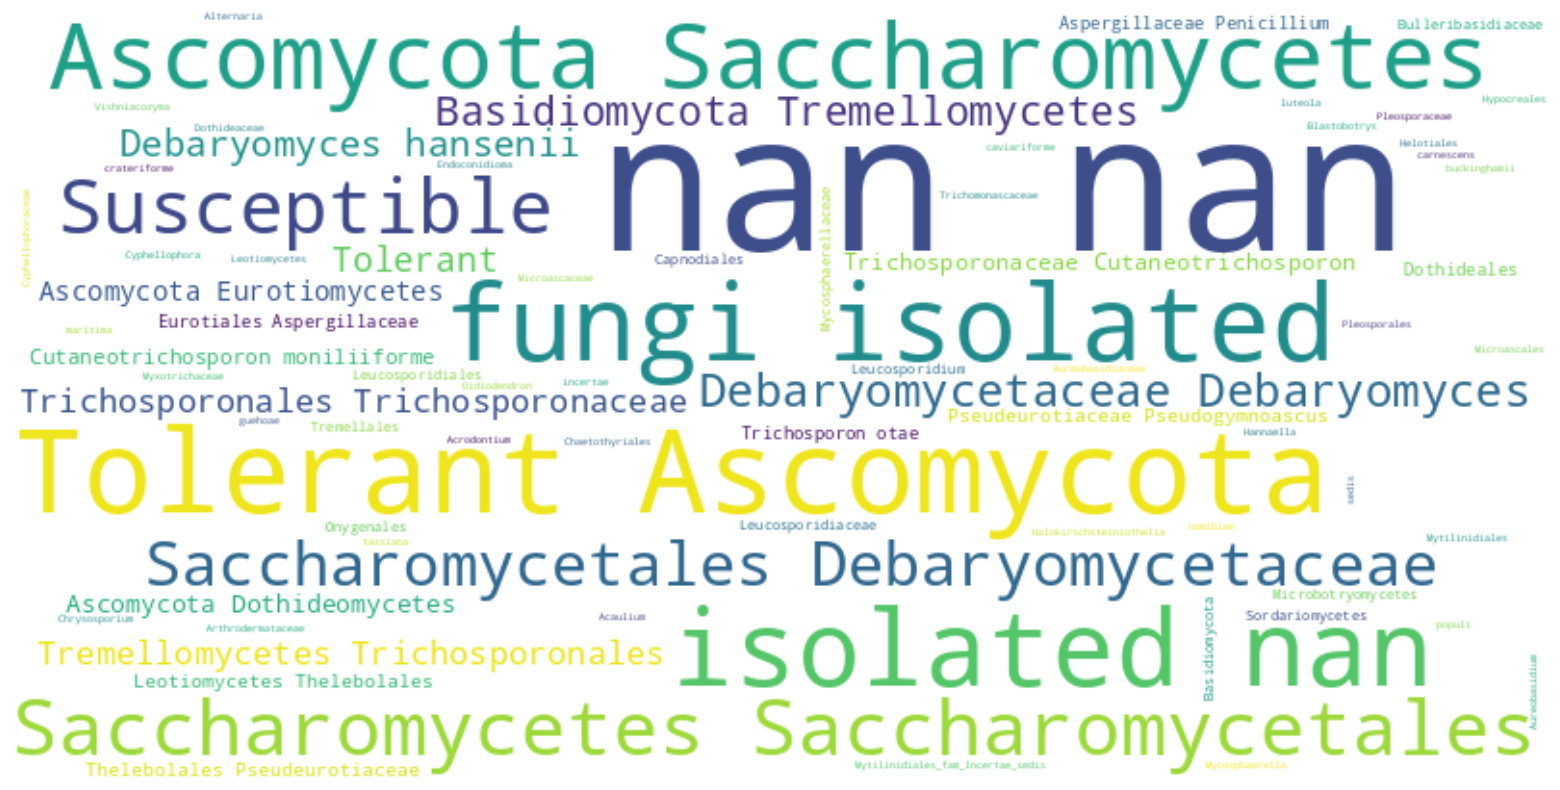

<Figure size 640x480 with 0 Axes>

In [ ]:
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",width=800, height=400).generate(true_neg)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('content\true_neg.eps', format='eps')

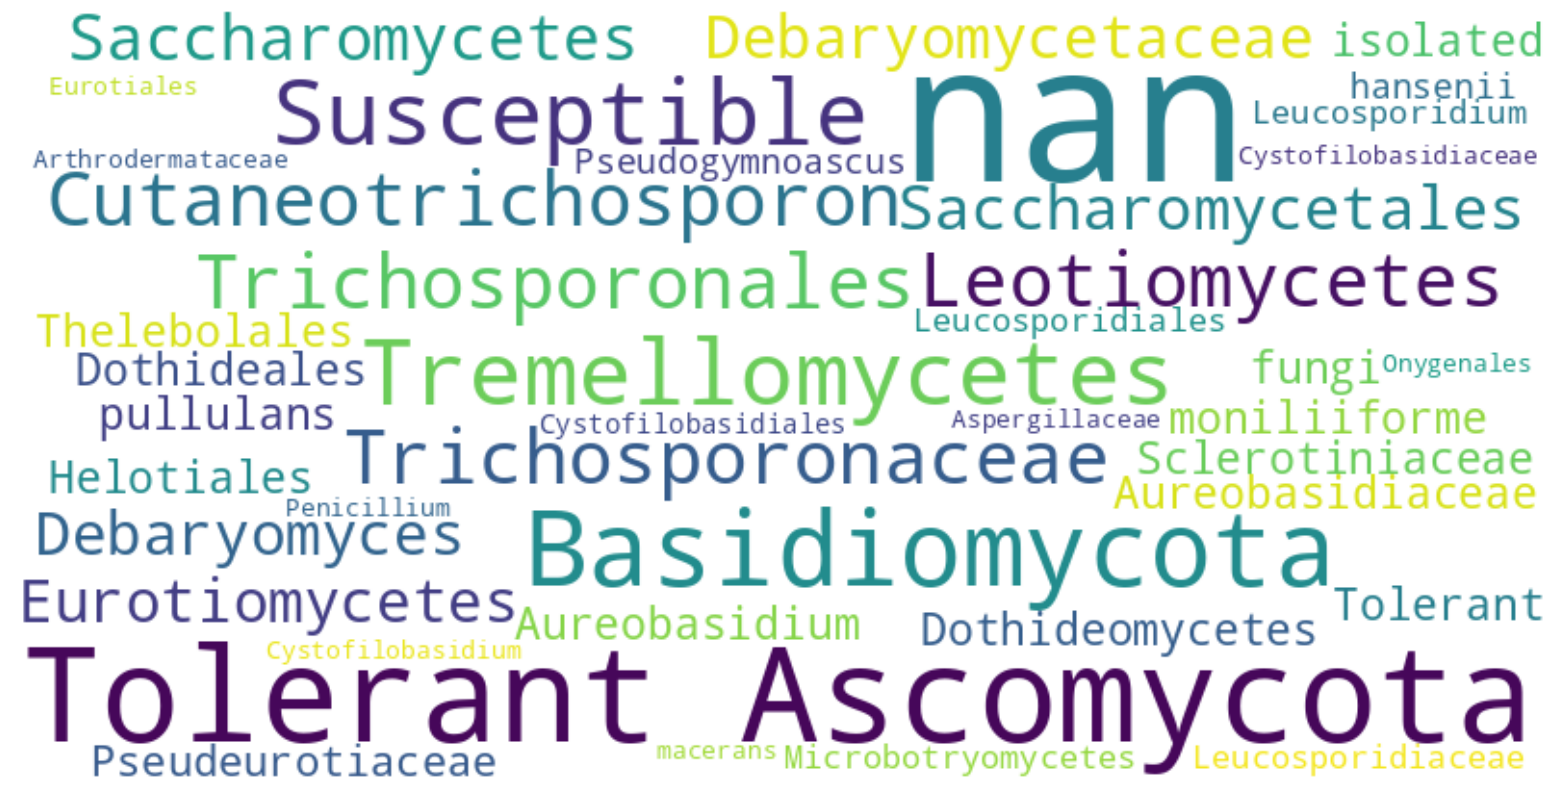

<Figure size 640x480 with 0 Axes>

In [ ]:
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",width=800, height=400).generate(false_neg)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('content\false_neg.eps', format='eps')

In [ ]:
x_test_list

['Tolerant no fungi isolated nan nan nan nan nan nan',
 'Tolerant 1 Ascomycota Leotiomycetes Helotiales Sclerotiniaceae nan nan',
 'Susceptible 100 Ascomycota Leotiomycetes Thelebolales Pseudeurotiaceae Pseudogymnoascus destructans',
 'Tolerant 50 Ascomycota Leotiomycetes Thelebolales Pseudeurotiaceae Pseudogymnoascus destructans',
 'Tolerant 5 Ascomycota Eurotiomycetes Eurotiales Aspergillaceae Penicillium nan',
 'nan no fungi isolated nan nan nan nan nan nan',
 'Tolerant 2 Ascomycota Eurotiomycetes Eurotiales Aspergillaceae Penicillium nan',
 'Susceptible 1 Basidiomycota Malasseziomycetes Malasseziales Malasseziaceae Malassezia nan',
 'Tolerant 2 Ascomycota Saccharomycetes Saccharomycetales Debaryomycetaceae Debaryomyces nan',
 'nan no fungi isolated nan nan nan nan nan nan',
 'Tolerant 12 Ascomycota Saccharomycetes Saccharomycetales Debaryomycetaceae Debaryomyces hansenii',
 'unassigned 13 Ascomycota Leotiomycetes Thelebolales Pseudeurotiaceae Pseudogymnoascus destructans',
 'Resist

In [ ]:

print(df_wns["Sample Location - State"].unique())
print(df_no_wns["Sample Location - State"].unique())

['West Virginia' 'Kentucky' 'New York' 'Wisconsin' 'Pennsylvania'
 'Arkansas' 'Washington']
['Wisconsin' 'Iowa' 'Alabama' 'Oklahoma' 'Idaho' 'Oregon' 'Texas' 'Utah'
 'Washington' 'Wyoming']


In [ ]:
print(df['combined'].head(10))

0    Resistant 6 Ascomycota Eurotiomycetes Onygenal...
1    Resistant 1 Ascomycota Saccharomycetes Sacchar...
2    Resistant 6 Ascomycota Saccharomycetes Sacchar...
3    Resistant 1 Ascomycota Saccharomycetes Sacchar...
4    Resistant 3 Ascomycota Saccharomycetes Sacchar...
5    Resistant 1 Ascomycota Saccharomycetes Sacchar...
6    Resistant 1 Ascomycota Saccharomycetes Sacchar...
7    Resistant 1 Ascomycota Saccharomycetes Sacchar...
8    Resistant 3 Basidiomycota Exobasidiomycetes Mi...
9    Resistant 3 Ascomycota Saccharomycetes Sacchar...
Name: combined, dtype: object


In [ ]:



vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['combined'])


In [ ]:
X.shape

(1502, 277)

In [ ]:
print(X)

  (0, 270)	1
  (0, 269)	1
  (0, 0)	1
  (0, 184)	1
  (1, 270)	1
  (1, 269)	1
  (1, 0)	1
  (1, 145)	1
  (2, 270)	1
  (2, 269)	1
  (2, 0)	1
  (2, 145)	1
  (3, 270)	1
  (3, 269)	1
  (3, 0)	1
  (3, 184)	1
  (4, 270)	1
  (4, 269)	1
  (4, 0)	1
  (4, 184)	1
  (5, 270)	1
  (5, 269)	1
  (5, 0)	1
  (5, 184)	1
  (6, 270)	1
  :	:
  (1495, 255)	1
  (1496, 217)	1
  (1496, 273)	1
  (1496, 272)	1
  (1496, 18)	1
  (1497, 184)	1
  (1497, 273)	1
  (1497, 272)	1
  (1497, 18)	1
  (1498, 184)	1
  (1498, 273)	1
  (1498, 272)	1
  (1498, 18)	1
  (1499, 184)	1
  (1499, 272)	1
  (1499, 274)	1
  (1499, 17)	1
  (1500, 272)	1
  (1500, 274)	1
  (1500, 17)	1
  (1500, 172)	1
  (1501, 133)	1
  (1501, 272)	1
  (1501, 17)	1
  (1501, 275)	1


In [ ]:
y = df['Fungus Classification - Phylum']

df.dropna(subset=['Fungus Classification - Phylum'], inplace=True)


In [ ]:
features = ['Sample Location - County', 'Sample Location - State', 'Sample Location - Site', 'Genbank', 'CFU', 'Fungus Classification - Class', 'Fungus Classification - Order', 'Fungus Classification - Family', 'Fungus Classification -Genus', 'Fungus Classification - Species', 'OTU (cluster)']
X = df[features]


In [ ]:
X_encoded = pd.get_dummies(X, columns=['Sample Location - County', 'Sample Location - State', 'Sample Location - Site', 'Fungus Classification - Class', 'Fungus Classification - Order', 'Fungus Classification - Family', 'Fungus Classification -Genus', 'Fungus Classification - Species', 'OTU (cluster)'])


In [ ]:
X_encoded.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)


In [ ]:
print(len(X_encoded), len(y))
#they're not same size

1171 1502


In [ ]:
print(X_encoded.duplicated().sum())
print(y.duplicated().sum())


3
1497


In [ ]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.0 MB/s eta 0:00:00
